<a href="https://colab.research.google.com/github/JuliyaGushchina/Project_prediction/blob/main/%22%D0%9F%D1%80%D0%B5%D0%B4%D1%81%D0%BA%D0%B0%D0%B7%D0%B0%D0%BD%D0%B8%D0%B5_%D1%81%D0%BA%D0%BE%D1%80%D0%BE%D0%BF%D0%BE%D1%80%D1%82%D0%B0_1ver_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# Загрузка данных




##Описание задачи

Предсказать продажи товаров категории "скоропортящиеся", то есть имеющие ограниченный срок употребления, в разрезе часов. Иными словами, предоставить рекомендательную систему для оператора АЗС с выкладкой хот-догов на гриль.

Задача:


*   Адресная программа - 45 АЗС
*   Категория товаров "Хот-доги"
*   Данные представлены с 01 июля 2023 по 01 августа 2024 годов
* Рекомендации должны содержать данные по реализации товара в разрезе часа, чтобы сотрудник успел выложить и приготовить необходимое количество
* Основные метрики оценки - RMSE, MSE, визуализация графиков остатков, расчетная оценка точности прогноза



## Импорт библиотек, установка констант

In [1]:
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error



from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor



## Загрузка данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
fact_csv = '/content/drive/MyDrive/data_fact.csv'
fuel_csv = '/content/drive/MyDrive/data_fuel.csv'
competitors_csv = '/content/drive/MyDrive/competitors.csv'

In [4]:
df_fact = pd.read_csv(fact_csv)                                              # факт продажи товаров

df_fuel = pd.read_csv(fuel_csv)                                              # факт трафика (чеки топливо)

df_competitor = pd.read_csv(competitors_csv, sep=';',encoding='utf-8')       # справочник АЗС по наличию конкурентов и ценовому сегменту АЗС

In [5]:
# приводим к единому формату времени
df_fact['date_trunc'] = pd.to_datetime(df_fact['date_trunc'], format='ISO8601')
df_fuel['dt'] = pd.to_datetime(df_fuel['dt'], format='ISO8601')

Создаем справочник дат, чтобы привести итоговый DataFrame к единому временному пространству в разрезе часов, соединив продажи товара и движение трафика

In [6]:
# создаем справочник дат
from datetime import datetime, timedelta

start_date = datetime.strptime('2023-07-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime('2024-08-01 00:00:00', '%Y-%m-%d %H:%M:%S')
daterange = [(start_date + timedelta(hours=x)).strftime('%Y-%m-%d %H:%M:%S') for x in range(0, (end_date-start_date).days  * 24)]
dictonary_date = pd.DataFrame(daterange, columns=['dt'])
dictonary_date['dt'] = pd.to_datetime(dictonary_date['dt'], format='ISO8601')

In [7]:
calendar_fuel = pd.merge(dictonary_date, df_fuel, how='inner', right_on = ['dt'], left_on = ['dt'])

In [8]:
calendar_fuel['dt'] = pd.to_datetime(calendar_fuel['dt'], format='ISO8601')

In [9]:
calendar_fact = pd.merge(df_fact, calendar_fuel, how='outer', right_on = ['dt', 'md5'], left_on = ['date_trunc','md5'])

Добавляем признаки для АЗС из Справочника

In [10]:
df = pd.merge(calendar_fact, df_competitor, how='left', right_on = ['md5'], left_on = ['md5'])

In [11]:
df.head(3)

,account_date,day_of_week,date_trunc,product_name_3,price,quantity,product_code_3,md5,location_ksss,geo_name,shop_area_range,lot_area,dt,sum_fuel_day,sum_fuel_hour,competitor,segment
0,2023-07-12,3.0,2023-07-12 09:00:00,Хот-доги,275.0,2.0,16073.0,e54bacb7737f0a180ed006df65f75e7b,федеральная трасса,Архангельск,60-120,"0,8",2023-07-12 09:00:00,836.0,30.0,Наличие АЗС С Кафе или отдельных объектов обще...,"1,1"
1,2023-07-12,3.0,2023-07-12 09:00:00,Хот-доги,225.0,2.0,16073.0,e54bacb7737f0a180ed006df65f75e7b,федеральная трасса,Архангельск,60-120,"0,8",2023-07-12 09:00:00,836.0,30.0,Наличие АЗС С Кафе или отдельных объектов обще...,"1,1"
2,2023-07-12,3.0,2023-07-12 09:00:00,Хот-доги,235.0,2.0,16073.0,e54bacb7737f0a180ed006df65f75e7b,федеральная трасса,Архангельск,60-120,"0,8",2023-07-12 09:00:00,836.0,30.0,Наличие АЗС С Кафе или отдельных объектов обще...,"1,1"


In [12]:
df.shape

(465893, 17)

Создадим копию dt, в который добавим потом предсказания, сформируем csv файл и на основании него предоставим BI-отчет с выводами.

In [11]:
# df1 = df.copy()

Описание полей данных:


*   account_date - дата
*   day_of_week - номер дня недели
*   date_trunc - дата со временем
*   product_name_3 - наименование категории
*   price - цена товара за единицу, руб.
*   quantity - количество проданных товаров, шт.
*   product_code_3 - ID категории
*   md5 - ID АЗС
*   location_ksss -  расположение АЗС относительно трасс/города
*   geo_name - географическое расположение АЗС
*   shop_area_range - площадь торгового зала
*   lot_area - координаты
*   dt - дата продажи с указанием времени
*   sum_fuel_day - количество топливных чеков на АЗС в рамках дня
*   sum_fuel_hour - количество топливных чеков на АЗС в рамках дня и часа
*   competitor - наличие одного из трех конкурентов (Вкусно и Точка, БК, Ростикс)
*   segment - ценовой семент АЗС

# Предварительная обработка данных

## Работа с отсутствующими данными

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 465893 entries, 0 to 465892
Data columns (total 17 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   account_date     232013 non-null  object        
 1   day_of_week      232013 non-null  float64       
 2   date_trunc       232013 non-null  datetime64[ns]
 3   product_name_3   232013 non-null  object        
 4   price            232013 non-null  float64       
 5   quantity         232013 non-null  float64       
 6   product_code_3   232013 non-null  float64       
 7   md5              465893 non-null  object        
 8   location_ksss    232013 non-null  object        
 9   geo_name         232013 non-null  object        
 10  shop_area_range  232013 non-null  object        
 11  lot_area         232013 non-null  object        
 12  dt               464693 non-null  datetime64[ns]
 13  sum_fuel_day     464693 non-null  float64       
 14  sum_fuel_hour    464

In [16]:
df.isnull().sum().sort_values()

,0
segment,0
md5,0
competitor,0
sum_fuel_hour,1200
sum_fuel_day,1200
dt,1200
lot_area,233880
shop_area_range,233880
geo_name,233880
account_date,233880


Из этой информации видим, что в признаках присутствует много пропусков, связанных с join outer фактов продажи товара (товар продается не каждый час) и трафиком (он более стабильный)

In [17]:
def percent_missing(df):
    percent_nan = 100* df.isnull().sum() / len(df)
    # percent_nan = percent_nan[percent_nan>0].sort_values()
    return percent_nan.sort_values()
percent_nan = percent_missing(df)
percent_nan

,0
segment,0.000000
md5,0.000000
competitor,0.000000
sum_fuel_hour,0.257570
sum_fuel_day,0.257570
dt,0.257570
lot_area,50.200368
shop_area_range,50.200368
geo_name,50.200368
account_date,50.200368


<ipython-input-18-0cfd09bb0d83>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=percent_nan.index,y=percent_nan, palette = 'YlOrBr')  #cubehelix  coolwarm  vlag    YlOrBr


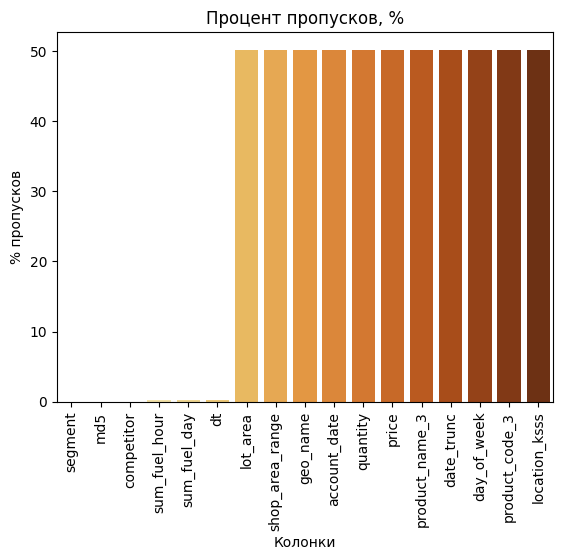

In [18]:
sns.barplot(x=percent_nan.index,y=percent_nan, palette = 'YlOrBr')  #cubehelix  coolwarm  vlag    YlOrBr
plt.title('Процент пропусков, %')
plt.xlabel("Колонки")
plt.ylabel("% пропусков")
plt.xticks(rotation=90)
plt.show();

Сначала поработаем со справочной информацией, ее заполним на основании данных по md5

In [12]:
lst = ['location_ksss', 'geo_name', 'shop_area_range', 'lot_area']
for i in lst:
    df.loc[df[i].isna(), i] = \
    df.loc[df[i].isna(), 'md5'].map(df.groupby('md5')[i].first())

Пустые значения в столбце dt заменим значениями из date_trunc

In [13]:
df['dt'] = df['dt']. fillna(df['date_trunc'])

Так как мы анализируем одну категорию "Хот-доги", то NaN в столбце product_name_3 заменим на "Хот-доги", в столбце product_code_3 - на 16073

In [14]:
df['product_name_3'] = df['product_name_3']. fillna('Хот-доги')
df['product_code_3'] = df['product_code_3']. fillna('16073')

Nan в столбцах quantity, price, sum_fuel_day, sum_fuel_hour говорит о том, что не было продаж либо товара либо отсутствовал трафик. Заменим на 0.

In [15]:
df[['quantity', 'price', 'sum_fuel_day', 'sum_fuel_hour']] = df[['quantity', 'price', 'sum_fuel_day', 'sum_fuel_hour']]. fillna(0)

Столбцы date_trunc, account_date, product_code_3 можно удалить, они дублируют информацию. Столбец day_of_week добавим позже, когда будем формировать новые признаки

In [16]:
df.drop(['date_trunc', 'day_of_week', 'account_date', 'product_code_3'], axis= 1 , inplace= True )

In [26]:
# df.isnull().sum().sort_values()

Отсутствующих значений нет.

## Обзор типов данных

In [24]:
df.dtypes

,0
product_name_3,object
price,float64
quantity,float64
md5,object
location_ksss,object
geo_name,object
shop_area_range,object
lot_area,object
dt,datetime64[ns]
sum_fuel_day,float64


По нескольким столбцам, которые относятся к дискретным признакам, заданы некорректные типы данных. Необходимо преобразовать их.

In [17]:
def convert_type(col):
    """
    Преобразует числовое значение строки в число с плавающей точкой:
     - удаляет запятые
     - преобразует в число с плавающей точкой
    """
    new_col = col.replace(',', '')
    return float(new_col)

In [18]:
df['lot_area'] = df['lot_area'].apply(convert_type)
df['segment'] = df['segment'].apply(convert_type)

# Анализ выбросов

In [25]:
df.describe(include = ['object']).transpose()

,count,unique,top,freq
product_name_3,465893,1,Хот-доги,465893
md5,465893,45,c1b70d965ca504aa751ddb62ad69c63f,15363
location_ksss,465893,4,федеральная трасса,183398
geo_name,465893,19,Санкт-Петербург,163732
shop_area_range,465893,3,<60,239031
competitor,465893,6,Наличие АЗС С Кафе или отдельных объектов обще...,126799


In [26]:
df.describe().transpose()

,count,mean,min,25%,50%,75%,max,std
price,465893.0,130.975175,0.0,0.0,0.0,259.0,1219.0,136.770844
quantity,465893.0,1.019316,0.0,0.0,0.0,1.0,42.0,1.655044
lot_area,465893.0,2712.79678,1.0,53.0,1666.0,4936.0,10769.0,3130.827229
dt,465893,2024-01-14 23:18:44.052947712,2023-07-01 00:00:00,2023-10-05 07:00:00,2024-01-13 00:00:00,2024-04-26 17:00:00,2024-07-31 23:00:00,NaN
sum_fuel_day,465893.0,470.354326,0.0,284.0,436.0,620.0,1415.0,234.481384
sum_fuel_hour,465893.0,21.202143,0.0,7.0,17.0,31.0,107.0,17.205831
segment,465893.0,5.21705,1.0,1.0,1.0,11.0,11.0,4.612387


# Коррелляционный анализ

In [27]:
!pip install phik

In [28]:
import phik

phik_corr = df.phik_matrix()

interval columns not set, guessing: ['price', 'quantity', 'lot_area', 'sum_fuel_day', 'sum_fuel_hour', 'segment']


/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable dt is large: 9528. Are you sure this is not an interval variable? Analysis for pairs of variables including dt can be slow.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable product_name_3 for analysis 1. Dropping this column
  warnings.warn(


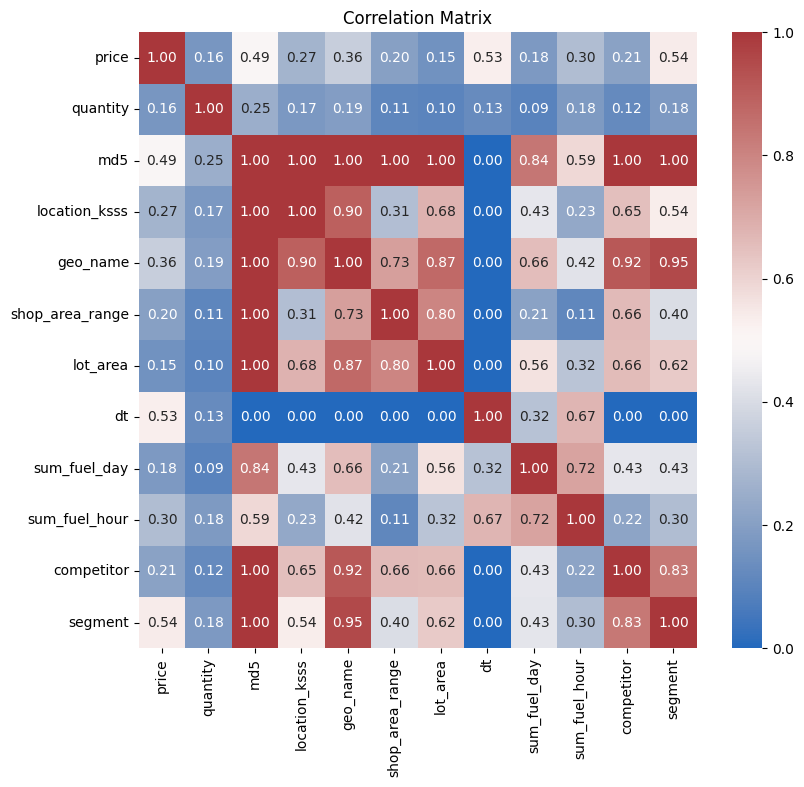

In [29]:
plt.figure(figsize=(9, 8))
sns.heatmap(phik_corr, annot=True, fmt=".2f", cmap="vlag", cbar=True)   #vlag  coolwarm  YlOrBr
plt.title("Correlation Matrix")
plt.show()

Матрица выявила признаки, которые имеют между собой высокую зависимость. Для уменьшения мультиколлинеарности исключим часть и оставим те, что наиболее влияют на целевой признак - quantity:


*   lot_area, geo_name (содержат дублирующую информацию)

In [19]:
df.drop([ 'lot_area','geo_name'], axis= 1 , inplace= True )

# Работа с признаками

## Частичное удаление признаков

product_name_3 можно удалить, он содержит одну уникальную запись - "Хот-доги", в задаче итак указано, что мы оцениваем эту категорию

In [20]:
df.drop(['product_name_3'], axis= 1 , inplace= True )

## Feature engineering

Выделим на основании столбца dt новые признаки: год, номер месяца, день месяца, час дня день недели

In [21]:
df['year'] = df.dt.dt.year
df['month'] = df.dt.dt.month
df['dayofmonth'] = df.dt.dt.day
df['hour'] = df.dt.dt.hour
df['dayofweek'] = df.dt.dt.dayofweek

In [22]:
df.drop(['dt'], axis= 1 , inplace= True )

Посмотрим на распределение продаж в течении дня, месяца

In [23]:
sales_day = df.groupby(["dayofmonth"]).quantity.sum().reset_index().set_index("dayofmonth")

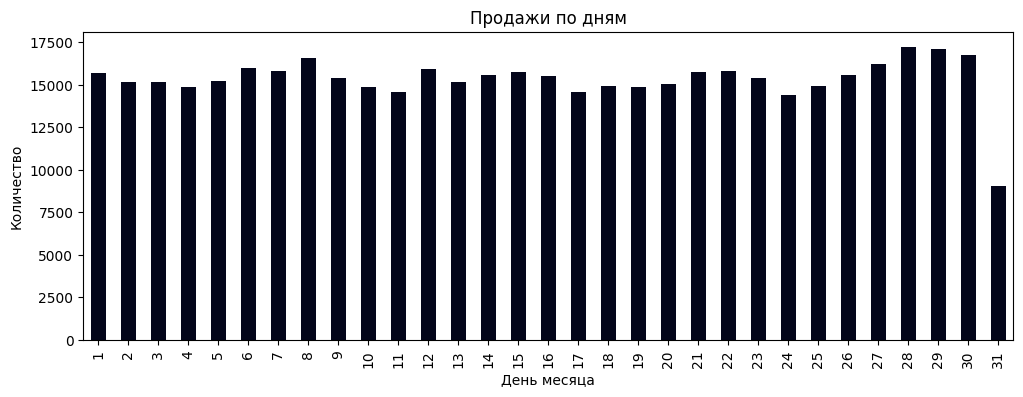

In [35]:
sales_day.plot(kind='bar', stacked=True, cmap="rocket", legend=False, figsize=(12, 4))  #vlag
plt.title("Продажи по дням")
plt.xlabel("День месяца")
plt.ylabel("Количество")
plt.show();

Продажи стабильны и не зависят от числа месяца. Наблюдаем небольшое снижение 31го числа, связанное с чередованием отсутствия этого дня в месяцах.

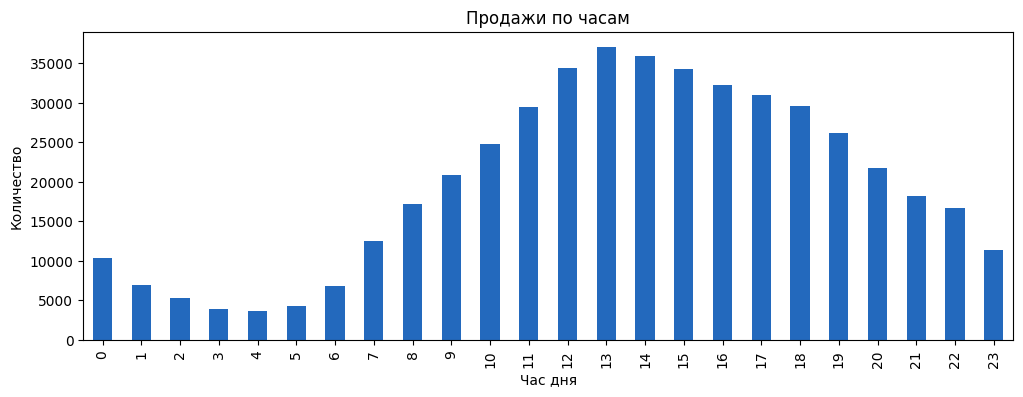

In [36]:
sales_hour = df.groupby(["hour"]).quantity.sum().reset_index().set_index("hour")   #"year", "dayofmonth",

sales_hour.plot(kind='bar', stacked=True, cmap="vlag", legend=False, figsize=(12, 4))  #vlag
plt.title("Продажи по часам")
plt.xlabel("Час дня")
plt.ylabel("Количество")
plt.show();

А вот продажи в течении дня, напротив, цикличны, пик наступает днем и снижение после полуночи до 5 утра.

Создадим столбец с конверсией товара в рамках дня

In [24]:
mean_conv = round(df['quantity'].mean()/df['sum_fuel_day'].mean(),4)

try:
     df['conv_day'] = round(df['quantity']/df['sum_fuel_day'], 4)
except ZeroDivisionError:
     df['conv_day'] = mean_conv

value = mean_conv
df['conv_day'] = df['conv_day'].replace(np.inf, value)

Посмотрим на столбец competitor. Он содержит 6 уникальных значений, из которых можно выделить бинарный признак "Есть конкурент/Нет конкурента" - столбец flag_compet

In [28]:
df.value_counts('competitor')

,count
competitor,
Наличие АЗС С Кафе или отдельных объектов общественного питания в радиусе 30км.,126799
"Наличие (Вкусно и точка, Бургер Кинг, KFC/Ростикс) с drive thru в радиусе 30км",111150
Наличие объектов общественного питания в шаговой доступности от АЗС,102120
"Наличие (Вкусно и точка, Бургер Кинг, KFC/Ростикс) с drive thru в шаговой доступности от АЗС",57531
Нет конкурентов,57222
Наличие АЗС только с магазином или отдельных стоячего магазина в радиусе 30км.,11071


In [25]:
df['flag_compet'] = np.where(df['competitor'] == 'Нет конкурентов', 'нет', 'да')

In [27]:
df_f = df.copy()

In [29]:
# df_f.head()

Удалим столбец md5, у нас есть index.

In [30]:
df.drop(['md5'], axis= 1 , inplace= True )

# Выбор модели

## Разбиение на обучающие и тестовые наборы, преобразование признаков

In [31]:
X = df.drop('quantity',axis=1)
y = df['quantity']

Преобразование признаков

In [32]:
df_nums = X.select_dtypes(exclude='object')
df_objs = X.select_dtypes(include='object')

#Категориальные признаки
# df_objs = pd.get_dummies(df_objs,drop_first=True)
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
df_objs = ohe.fit_transform(df_objs)

#Дискретные признаки
scaler = StandardScaler()
df_nums = scaler.fit_transform(df_nums)

In [33]:
column_names_num = X.select_dtypes(exclude='object').columns.tolist()
column_names_num

['price',
 'sum_fuel_day',
 'sum_fuel_hour',
 'segment',
 'year',
 'month',
 'dayofmonth',
 'hour',
 'dayofweek',
 'conv_day']

In [34]:
X = pd.concat([pd.DataFrame(df_nums, columns=column_names_num),
                pd.DataFrame(df_objs, columns=ohe.get_feature_names_out()),
                ],axis=1)
X.head(3)

,price,sum_fuel_day,sum_fuel_hour,segment,year,month,dayofmonth,hour,dayofweek,conv_day,...,shop_area_range_120-180,shop_area_range_60-120,shop_area_range_<60,"competitor_Наличие (Вкусно и точка, Бургер Кинг, KFC/Ростикс) с drive thru в радиусе 30км","competitor_Наличие (Вкусно и точка, Бургер Кинг, KFC/Ростикс) с drive thru в шаговой доступности от АЗС",competitor_Наличие АЗС С Кафе или отдельных объектов общественного питания в радиусе 30км.,competitor_Наличие АЗС только с магазином или отдельных стоячего магазина в радиусе 30км.,competitor_Наличие объектов общественного питания в шаговой доступности от АЗС,competitor_Нет конкурентов,flag_compet_да
0,1.053039,1.559382,0.511331,1.253788,-1.061441,0.117745,-0.431261,-0.462529,-0.516513,-0.013308,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,0.687463,1.559382,0.511331,1.253788,-1.061441,0.117745,-0.431261,-0.462529,-0.516513,-0.013308,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0.760578,1.559382,0.511331,1.253788,-1.061441,0.117745,-0.431261,-0.462529,-0.516513,-0.013308,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Итак, мы реализовали EDA и получили 24 признака.

Разбиение на выборки

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Вспомогательная функция для запуска моделей

In [36]:
def run_model(model,X_train,y_train,X_test,y_test):

    # Обучение модели
    model.fit(X_train,y_train)

    # Вычисление предсказания и метрик. Для предсказания используем математическое округление, так как товар штучный

    preds = model.predict(X_test)      #np.round(abs((model.predict(X_test))))

    rmse = np.sqrt(mean_squared_error(y_test,preds))
    mae = mean_absolute_error(y_test,preds)
    mape = mean_absolute_percentage_error(y_test,preds)
    print(f'RMSE : {rmse}')
    print(f'MAE : {mae}')


    # Рисуем график с указанием количества предсказанных значений

    preds = np.round(abs(preds))
    y_hats_df = pd.DataFrame(data = preds, columns = ['preds'], index = X_test.index.copy())
    df_out = pd.merge(df, y_hats_df, how = 'left', left_index = True, right_index = True)
    df_out = df_out.dropna(subset=['preds'])
    df_out['Flag'] = np.where(df_out['preds'] == df_out['quantity'] , 1, 0)

    accuracy = sum(df_out['Flag'])/len(df_out) * 100
    print(f'Accuracy : {accuracy}')
    sns.set_style('whitegrid')
    plt.figure(figsize=(8,5))

    ax = sns.countplot(data=df_out, x='Flag', hue = 'Flag', palette='Set1')    #YlOrBr_r   Set2   palette = "YlOrBr_r"  ,  Set3  dark:salmon
    sns.despine(left=True)
    ax.bar_label(ax.containers[0], label_type='center')
    ax.bar_label(ax.containers[1], label_type='center')
    plt.title('Предсказание верно - 1, неверно - 0', fontsize=20)




## ElasticNet

Для улучшения модели используем подбор гиперпарметров

In [47]:
elastic_model = ElasticNet()

In [48]:
param_grid = {'alpha':[0.1,1,5,10,50,100],
              'l1_ratio':[.1, .5, .7, .9, .95, .99, 1]}

In [49]:
grid_model = GridSearchCV(estimator=elastic_model,
                          param_grid=param_grid,
                          scoring='neg_mean_squared_error',
                          cv=5,
                          verbose=1)

In [50]:
grid_model.fit(X_train,y_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': [0.1, 1, 5, 10, 50, 100],
                         'l1_ratio': [0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
             scoring='neg_mean_squared_error', verbose=1)

In [51]:
grid_model.best_params_

{'alpha': 0.1, 'l1_ratio': 0.1}

Определились с гиперпараметрами: {'alpha': 0.1, 'l1_ratio': 0.1}

In [52]:
elastic_model_cor = ElasticNet(alpha= 0.1, l1_ratio = 0.1)

RMSE : 0.8383407419212183
MAE : 0.4412283057867348
Accuracy : 75.25256138744206


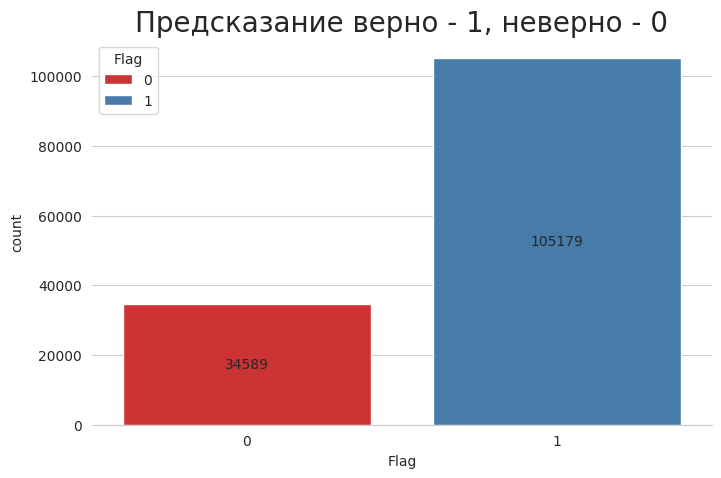

In [53]:
run_model(elastic_model_cor,X_train,y_train,X_test,y_test)

## Случайные леса

In [37]:
model_rf = RandomForestRegressor(n_estimators=50)

RMSE : 0.06922450802294126
MAE : 0.003071375422128095
Accuracy : 99.81970121916318


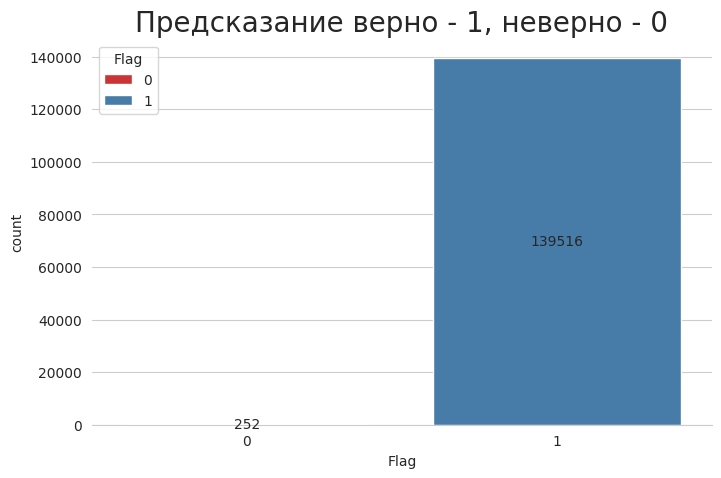

In [39]:
run_model(model_rf,X_train,y_train,X_test,y_test)

Посмотрим на признаки

In [40]:
# feat_import = model_rf.feature_importances_
# imp_feats = pd.DataFrame(index=X.columns,data=feat_import,columns=['Importance'])
# imp_feats.sort_values("Importance",ascending=False)

## Градиентный бустинг

RMSE : 0.09494820583012144
MAE : 0.042476197092905545
Accuracy : 99.5928968004121


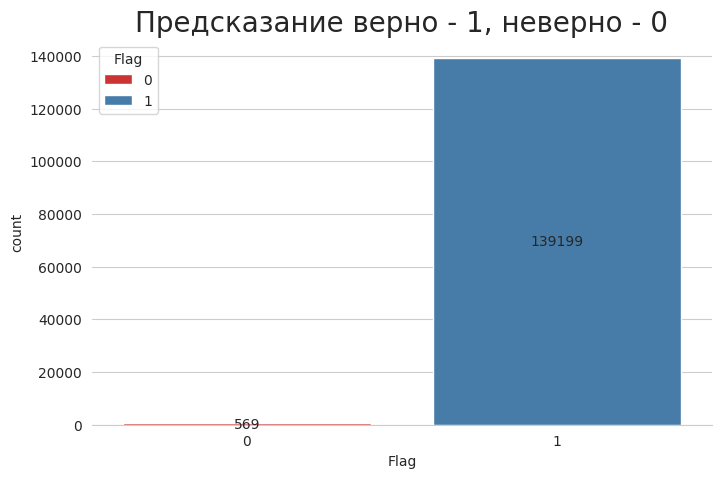

In [40]:
model_gb = GradientBoostingRegressor()

run_model(model_gb,X_train,y_train,X_test,y_test)

Посмотрим на признаки

In [46]:
feat_import = model_gb.feature_importances_
imp_feats = pd.DataFrame(index=X.columns,data=feat_import,columns=['Importance'])
imp_feats.sort_values("Importance",ascending=False)

,Importance
conv_day,7.160115e-01
sum_fuel_day,2.205527e-01
price,6.050704e-02
sum_fuel_hour,2.911640e-03
month,6.204845e-06
dayofweek,4.551845e-06
hour,2.325212e-06
location_ksss_федеральная трасса,1.727688e-06
shop_area_range_120-180,1.189410e-06
location_ksss_спальный район,1.158300e-06


## Выбор модели, отбор признаков

Лучше всего показала себя модель случайного леса, попробуем улучшить ее, убрав часть признаков. Посмотрим еще раз на них. Оставим те, где Importance > 0.0001

In [41]:
feat_import = model_rf.feature_importances_
imp_feats = pd.DataFrame(index=X.columns,data=feat_import,columns=['Importance'])
imp_feats.sort_values("Importance",ascending=False)

,Importance
conv_day,0.702150
sum_fuel_day,0.239120
price,0.057415
hour,0.000318
sum_fuel_hour,0.000311
dayofmonth,0.000221
dayofweek,0.000138
month,0.000117
segment,0.000026
location_ksss_федеральная трасса,0.000026


In [42]:
list_f = ['conv_day', 'sum_fuel_day','price', 'sum_fuel_hour', 'hour', 'dayofmonth', 'dayofweek', 'month']

In [43]:
X_train, X_test = X_train[list_f], X_test[list_f]

RMSE : 0.07038988959423259
MAE : 0.002975359166618966
Accuracy : 99.8254249899834


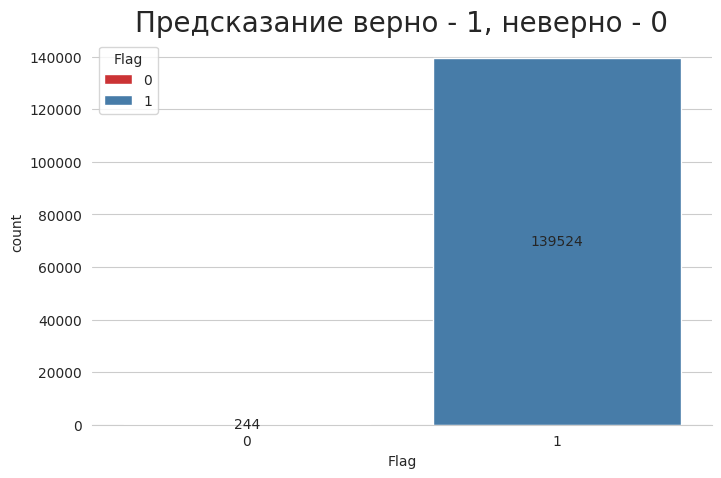

In [44]:
run_model(model_rf,X_train,y_train,X_test,y_test)

Улучшение модели незначительное, но это на тесте. Применим модель на весь датасет.

## Реализация модели, выгрузка в csv

In [45]:
X = X[list_f]

In [46]:
model_rf.fit(X,y)

preds = model_rf.predict(X)

In [47]:
preds = np.round(abs(preds))

In [48]:
hats = pd.DataFrame(data = preds, columns = ['preds'], index = X.index.copy())
df_final = pd.merge(df_f, hats, how = 'left', left_index = True, right_index = True)


In [49]:
df_final.head()

,price,quantity,md5,location_ksss,shop_area_range,sum_fuel_day,sum_fuel_hour,competitor,segment,year,month,dayofmonth,hour,dayofweek,conv_day,flag_compet,preds
0,275.0,2.0,e54bacb7737f0a180ed006df65f75e7b,федеральная трасса,60-120,836.0,30.0,Наличие АЗС С Кафе или отдельных объектов обще...,11.0,2023,7,12,9,2,0.0024,да,2.0
1,225.0,2.0,e54bacb7737f0a180ed006df65f75e7b,федеральная трасса,60-120,836.0,30.0,Наличие АЗС С Кафе или отдельных объектов обще...,11.0,2023,7,12,9,2,0.0024,да,2.0
2,235.0,2.0,e54bacb7737f0a180ed006df65f75e7b,федеральная трасса,60-120,836.0,30.0,Наличие АЗС С Кафе или отдельных объектов обще...,11.0,2023,7,12,9,2,0.0024,да,2.0
3,329.0,1.0,d072677d210ac4c03ba046120f0802ec,федеральная трасса,<60,568.0,13.0,Наличие АЗС только с магазином или отдельных ...,11.0,2023,12,27,5,2,0.0018,да,1.0
4,259.0,1.0,d072677d210ac4c03ba046120f0802ec,федеральная трасса,<60,568.0,13.0,Наличие АЗС только с магазином или отдельных ...,11.0,2023,12,27,5,2,0.0018,да,1.0


In [50]:
df_final['Flag'] = np.where(df_final['preds'] == df_final['quantity'] , 1, 0)

accuracy = sum(df_final['Flag'])/len(df_final) * 100
print(f'Accuracy : {accuracy}')

Accuracy : 99.96114987776164


In [55]:
# df_final.head()

Результат отличный, выгружаем данные в csv и визуализируем в PBI

In [51]:
df_final.to_csv('preds.csv')